# Setup

In [7]:
import dataloader
import torch
import numpy as np
import argparse
import importlib
importlib.reload(dataloader)

<module 'dataloader' from '/u/nyw6dh/HCDM/Archive/Experiment/LearnabilityLock2/dataloader.py'>

In [8]:
# Arguments ===================================
parser = argparse.ArgumentParser()

parser.add_argument('--gpu_id', type=int, default=1)
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--config', type=str, default='config.yaml')
parser.add_argument('--dataset', type=str, default='cora', choices=['cora', 'citeseer', 'BlogCatalog', 'flickr', 'Polblogs'])
parser.add_argument('--g0_method', type=str, default='random', choices=[
  'random', # randomly distribution of g0
  'bias', # a random class has a 3x higher likelihood of being in g0
  'large_cluster', # a random node and [g0_size] of its neighbors are in g0
  'many_clusters', # 10 random nodes and [g0_size] of their neighbors are in g0
  ])
parser.add_argument('--g0_size', type=float, default=0.1)
parser.add_argument('--attack_method', type=str, default='sll_no_g', choices=[
  'sll', # Selective Learnability Lock
  'sll_no_g', # Disable gradient guidance
  'noise', # Noise protection
  'heuristic' # Heuristic protection
  ])
parser.add_argument('--budget_pct', type=float, default=0.25)
parser.add_argument('--attack_epochs', type=int, default=30)
parser.add_argument('--save_results', type=str, default='Y', choices=['N', 'Y'])
parser.add_argument('--save_graph', type=str, default='N', choices=['N', 'Y'])

args = parser.parse_args("")

if args.gpu_id >= 0:
  device = torch.device(f'cuda:{args.gpu_id}' if torch.cuda.is_available() else 'cpu')
else:
  device = torch.device('cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

import yaml
from yaml import SafeLoader
config = yaml.load(open('config.yml'), Loader=SafeLoader)[args.dataset]

In [9]:
# Load graph ===================================
graph = dataloader.load_DGL(args.dataset)
feat = graph.ndata['feat'].to(device)
labels = graph.ndata['label'].to(device)
adj = graph.adj().to_dense()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [10]:
# Designate g0 ===================================
g0_size = int(args.g0_size * graph.num_nodes())

def get_clusters(num_roots: int, max_hops: int, target_size: int) -> torch.tensor:
  root_nodes = torch.rand(graph.num_nodes()).topk(num_roots).indices

  for hop in range(max_hops):
    newNodes = adj[root_nodes].nonzero().t()[1]
    root_nodes = torch.cat((root_nodes, newNodes))
    root_nodes = torch.unique(root_nodes)
    if root_nodes.shape[0] >= target_size:
      break

  g0 = torch.zeros(graph.num_nodes())
  g0[root_nodes[:target_size]] = 1
  g0 = g0.bool()
  return g0

if args.g0_method == 'many_clusters': # 10 nodes and their neighbors
  g0 = get_clusters(10, 10, g0_size)
elif args.g0_method == 'large_cluster': # 1 node and its neighbors
  g0 = get_clusters(1, 10, g0_size)
elif args.g0_method == 'random': # g0 is random/bias
  g0_probs = torch.ones(graph.num_nodes())
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()
elif args.g0_method == 'bias': # g0 is skewed toward a class by factor of 3
  bias = torch.randint(0, labels.max() + 1, [1]).item()
  print(f'G0 class bias: {bias}')
  g0_probs = torch.ones(graph.num_nodes())
  g0_probs[labels == bias] = 3
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()

print(f'G0 size: {g0.sum().item()}')
print(f'G0 pct: {g0.sum().item() / graph.num_nodes():.2%}')

g0 = g0.cpu()
gX = ~g0

G0 size: 285
G0 pct: 10.52%


# Do Attack

In [11]:
import importlib
import sampling_matrix
importlib.reload(sampling_matrix)

<module 'sampling_matrix' from '/u/nyw6dh/HCDM/Archive/Experiment/LearnabilityLock2/sampling_matrix.py'>

In [12]:
# Perform attack ==========================
accum_grad = []
sampling_r = [[], [], []]
losses = []

import utils
import models
import torch.nn.functional as F
from tqdm import tqdm

num_perturbations = (graph.num_edges()) * args.budget_pct

print(f'Attacking with method: {args.attack_method}')

if args.attack_method == 'heuristic':
  locked_adj = adj.clone()
  locked_adj[:, g0] = 0
  locked_adj[g0, :] = 0
elif args.attack_method == 'noise':
  noise = torch.zeros_like(adj)
  noise[g0, :] = 1
  noise[:, gX] = 0
  noise *= 2 * num_perturbations / noise.sum()
  noise = torch.bernoulli(noise.clamp(0, 1))
  noise = utils.make_symmetric(noise)
  locked_adj = utils.get_modified_adj(adj, noise)
elif args.attack_method == 'sll_no_g':

  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  surrogate = models.DenseGCN(
      in_size=feat.shape[1],
      out_size=labels.max().item()+1,
      hid_size=config['hid_size'],
      lr=config['lr'],
      dropout=config['dropout'],
      weight_decay=config['weight_decay']
  ).to(device)

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL (no gradient guidance)")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).requires_grad_(True).float().to(device)

    # Get grad of modified adj w.r.t attack loss
    pred = surrogate(feat, modified_adj)
    loss = F.cross_entropy(pred[g0], labels[g0]) \
        - F.cross_entropy(pred[gX], labels[gX])
    adj_grad = torch.autograd.grad(loss, modified_adj)[0].cpu()


    # Update perturbations
    lr = (config['sll_no_g_lr']) / ((epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    perturbations = utils.projection(perturbations, num_perturbations)

    accum_grad.append((lr * adj_grad))

    # Train the surrogate
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    model_loss = surrogate.fit(feat, modified_adj, labels, epochs=1, verbose=False)

    losses.append(loss.item())


    t.set_postfix({"adj_l": loss.item(),
                    "adj_g": (adj_grad.sum().item()),
                    "pre-p": pre_projection,
                    "target": int(num_perturbations),
                    "model_loss": model_loss})
elif args.attack_method == 'sll':

  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Initialize sampling matrix
  import sampling_matrix
  samplingMatrix = sampling_matrix.SamplingMatrix(
    g0=g0, gX=gX, adj=adj, sample_size=config['sll_sample_size'])
  count = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  surrogate = models.DenseGCN(
      in_size=feat.shape[1],
      out_size=labels.max().item()+1,
      hid_size=config['hid_size'],
      lr=config['lr'],
      dropout=config['dropout'],
      weight_decay=config['weight_decay']
  ).to(device)

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    g0_r, gX_r, g0gX_r = samplingMatrix.getRatio(verbose=False)
    for i, v in enumerate([g0_r, gX_r, g0gX_r]):
      sampling_r[i].append(v.item())

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).float().to(device)

    for sample_epoch in range(config['sll_num_samples']): 
      # Get sample indices
      idx = samplingMatrix.get_sample()

      # Map sample to adj
      sample = modified_adj[idx[0], idx[1]].clone().detach().requires_grad_(True).to(device)
      modified_adj[idx[0], idx[1]] = sample

      # Get grad
      pred = surrogate(feat, modified_adj)
      loss = F.cross_entropy(pred[g0], labels[g0]) \
          - F.cross_entropy(pred[gX], labels[gX])

      grad = torch.autograd.grad(loss, sample)[0]

      # Implement averaging of duplicate samples
      adj_grad[idx[0], idx[1]] += grad.cpu()
      count[idx[0], idx[1]] += 1

    # Update the sampling matrix
    samplingMatrix.updateByGrad(adj_grad, count)

    # Average the gradient
    adj_grad = torch.div(adj_grad, count)
    adj_grad[adj_grad != adj_grad] = 0
    
    # Update perturbations
    lr = (config['sll_lr']) / ((epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    accum_grad.append((lr * adj_grad))

    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the model
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    model_loss = surrogate.fit(feat, modified_adj, labels, epochs=1, verbose=False)

    losses.append(loss.item())

    t.set_postfix({"attack_loss": loss.item(),
                    # "adj_g": (adj_grad.sum().item()),
                    "pre-projection": pre_projection,
                    "target": int(num_perturbations),
                    "surrogate_loss": model_loss})

# Discretize the best locked_adj ============
if args.attack_method in ['sll', 'sll_no_g']:
  locked_adj = None
  with torch.no_grad():
    max_loss = -1000
    for k in range(0,3):
        sample = torch.bernoulli(perturbations)
        modified_adj = utils.get_modified_adj(adj, sample)
        modified_adj = utils.make_symmetric(modified_adj) 
        predictions = surrogate(feat, modified_adj.to(device)) 

        loss = F.cross_entropy(predictions[g0], labels[g0]) \
            - F.cross_entropy(predictions[gX], labels[gX])

        if loss > max_loss:
            max_loss = loss
            locked_adj = modified_adj
    
    print(f"Best sample loss: {max_loss:.2f}")

diff = adj - locked_adj
print(f'Edges modified: {diff.abs().sum() / 2:.0f}')

Attacking with method: sll_no_g


SLL (no gradient guidance): 100%|██████████| 30/30 [00:10<00:00,  2.97it/s, adj_l=0.45, adj_g=-633, pre-p=2640, target=2639, model_loss=1.6]     


Best sample loss: 0.16
Edges modified: 1387


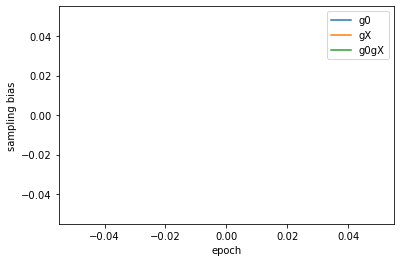

In [13]:
import matplotlib.pyplot as plt
data = torch.tensor(sampling_r).numpy()

plt.plot(data[0], label='g0')
plt.plot(data[1], label='gX')
plt.plot(data[2], label='g0gX')
plt.xlabel('epoch')
plt.ylabel('sampling bias')
plt.legend()
plt.show()

In [14]:
sll_loss = losses

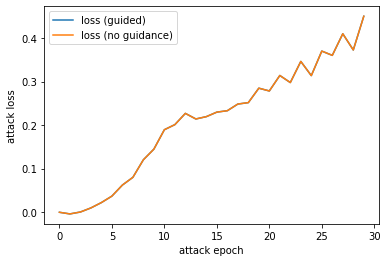

In [15]:
import matplotlib.pyplot as plt
data = torch.tensor(sampling_r).numpy()

plt.plot(sll_loss, label='loss (guided)')
plt.plot(losses, label='loss (no guidance)')
plt.xlabel('attack epoch')
plt.ylabel('attack loss')
plt.legend()
plt.show()

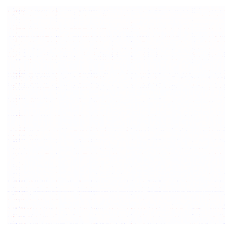

In [16]:
mat = accum_grad[0]
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(mat, cmap=plt.cm.seismic, interpolation='none', vmin=-1, vmax=1)

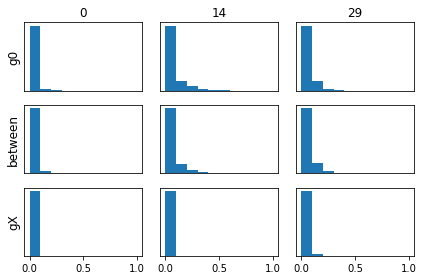

In [17]:
import numpy as np
import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 4))


for e, epoch in enumerate([0, 14, 29]):
  mat = accum_grad[epoch].abs()
  mat = mat / mat.max()
  # overall = mat.flatten()
  g0_grad = mat[g0, :][:, g0].flatten()
  g0gX_grad = mat[g0, :][:, gX].flatten()
  gX_grad = mat[gX, :][:, gX].flatten()

  for loc, grad in enumerate([g0_grad, g0gX_grad, gX_grad]):
    fig = axes[loc, e]
    fig.hist(grad[grad != 0].numpy(), bins=np.arange(0, 1.1, 0.1))
    # grad = grad / grad.max()
    fig.axes.get_xaxis().set_visible(False)
    fig.set_yticks([])
    # axis[0, 0].ylabel('frequency')

for ax, col in zip(axes[0], ['0', '14', '29']):
    ax.set_title(col)

for ax, col in zip(axes[2], ['0', '14', '29']):
    ax.axes.get_xaxis().set_visible(True)

for ax, row in zip(axes[:,0], ['g0', 'between', 'gX']):
    ax.set_ylabel(row, rotation=90, size='large')

figure.tight_layout()
plt.show() 

In [18]:
sll_grad = []
for t in accum_grad:
  sll_grad.append(t.clone())

sll_no_g


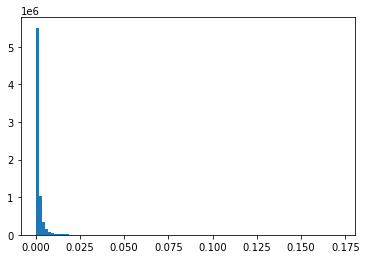

In [19]:
import numpy as np
import matplotlib.pyplot as plt
print(args.attack_method)
vals = accum_grad[0].abs().flatten()
plt.hist(vals[vals != 0].numpy(), bins=100)
plt.show()

sll_no_g


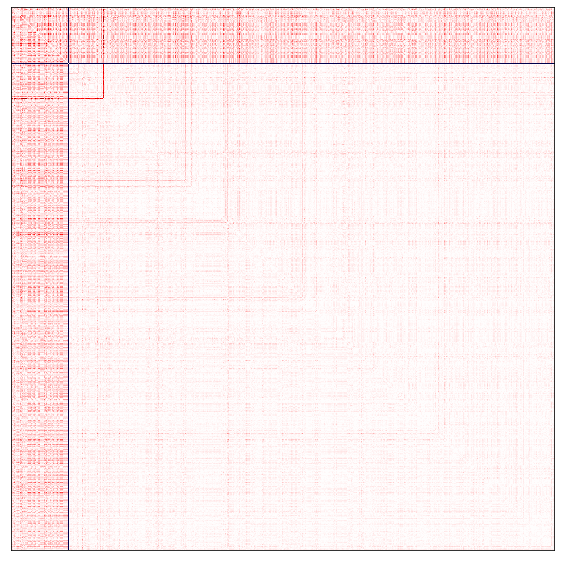

In [20]:
import numpy as np
import matplotlib.pyplot as plt

mat = accum_grad[1].abs()
mat = mat / mat.max()
m1 = torch.zeros_like(mat)
m1[0:g0.sum()] = mat[g0]
m1[g0.sum():g0.sum() + gX.sum()] = mat[gX]

m2 = torch.zeros_like(mat)
m2[:, 0:g0.sum()] = m1[:, g0]
m2[:, g0.sum():g0.sum() + gX.sum()] = m1[:, gX]

gap = 2
m2[:, g0.sum() - gap: g0.sum() + gap] = -1
m2[g0.sum() - gap: g0.sum() + gap, :] = -1
m2 = utils.make_symmetric(m2)

plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(m2, cmap=plt.cm.seismic, interpolation='none', vmin=-1, vmax=1)
print(args.attack_method)
plt.show()

# Eval

In [21]:
# Evaluation ==============================
import sklearn.metrics as metrics
gX_train = torch.logical_and(gX, graph.ndata['train_mask'])
gX_test = torch.logical_and(gX, graph.ndata['test_mask'])

def eval_adj(test_adj: torch.tensor):
    model = models.DenseGCN(
        in_size=feat.shape[1],
        out_size=labels.max().item()+1,
        hid_size=config['hid_size'],
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)
    model.fit(feat, test_adj, labels, epochs=100, mask=gX_train)
    pred = model(feat, test_adj).cpu()

    f1_g0 = metrics.f1_score(labels[g0].cpu(), pred.argmax(dim=1)[g0], average='micro')
    f1_gX = metrics.f1_score(labels[gX_test].cpu(), pred.argmax(dim=1)[gX_test], average='micro')
    
    return f1_g0, f1_gX

f1_g0_base, f1_gX_base = eval_adj(adj)
f1_g0_lock, f1_gX_lock = eval_adj(locked_adj)

d_g0 = (f1_g0_lock - f1_g0_base) / f1_g0_base
d_gX = (f1_gX_lock - f1_gX_base) / f1_gX_base


GCN Training: 100%|██████████| 100/100 [00:01<00:00, 63.99it/s, loss=0.47]


In [22]:
import importlib
importlib.reload(utils)

H_overall = utils.calc_homophily(adj, labels)

H_g0_base = utils.calc_homophily(adj, labels, g0)
H_gX_base = utils.calc_homophily(adj, labels, gX)
H_g0gX_base = utils.inner_homophily(adj, labels, g0, gX)

H_g0_lock = utils.calc_homophily(locked_adj, labels, g0)
H_gX_lock = utils.calc_homophily(locked_adj, labels, gX)
H_g0gX_lock = utils.inner_homophily(locked_adj, labels, g0, gX)

d_H_g0 = (H_g0_lock - H_g0_base) / H_g0_base
d_H_gX = (H_gX_lock - H_gX_base) / H_gX_base
d_H_g0gX = (H_g0gX_lock - H_g0gX_base) / H_g0gX_base

changes_g0 = diff[g0, :][:, g0].abs().sum().item()
changes_gX = diff[gX, :][:, gX].abs().sum().item()
changes_g0gX = diff.abs().sum().item() - (changes_g0 + changes_gX)

print(f'H Overall: {H_overall:.1%}')
print(f'ACC      f1_g0\tf1_gX\tH_g0\tH_gX\tH_g0gX')
print(f'base   | {f1_g0_base:.1%}\t{f1_gX_base:.1%}\t{H_g0_base:.1%}\t{H_gX_base:.1%}\t{H_g0gX_base:.1%}')
print(f'lock   | {f1_g0_lock:.1%}\t{f1_gX_lock:.1%}\t{H_g0_lock:.1%}\t{H_gX_lock:.1%}\t{H_g0gX_lock:.1%}')
print(f'delta  | {d_g0:.1%}\t{d_gX:.1%}\t{d_H_g0:.1%}\t{d_H_gX:.1%}\t{d_H_g0gX:.1%}')

print(f'Changes')
print(f'g0: {changes_g0}')
print(f'gX: {changes_gX}')
print(f'g0gX: {changes_g0gX}')

H Overall: 81.0%
ACC      f1_g0	f1_gX	H_g0	H_gX	H_g0gX
base   | 72.6%	72.5%	84.6%	81.7%	81.0%
lock   | 46.0%	70.1%	29.9%	80.9%	67.4%
delta  | -36.7%	-3.4%	-64.7%	-0.9%	-16.8%
Changes
g0: 288.0
gX: 464.0
g0gX: 2022.0


In [23]:
# Save the results
import export
import importlib
importlib.reload(utils)

results = {
  'dataset': args.dataset,
  'seed': args.seed,
  'config': args.config,
  'g0_method': args.g0_method,
  'g0_size': args.g0_size,
  'attack_epochs': args.attack_epochs,
  'attack_method': args.attack_method,
  'budget_pct': args.budget_pct,
  'f1_g0_base': f1_g0_base,
  'f1_gX_base': f1_gX_base,
  'f1_g0_lock': f1_g0_lock,
  'f1_gX_lock': f1_gX_lock,
  'd_g0': d_g0,
  'd_gX': d_gX,
  'H_overall': H_overall,
  'H_g0_base': H_g0_base,
  'H_gX_base': H_gX_base,
  'H_g0gX_base': H_g0gX_base,
  'H_g0_lock': H_g0_lock,
  'H_gX_lock': H_gX_lock,
  'H_g0gX_lock': H_g0gX_lock,
  'd_H_g0': d_H_g0,
  'd_H_gX': d_H_gX,
  'd_H_g0gX': d_H_g0gX,
  'changes_g0': changes_g0,
  'changes_gX': changes_gX,
  'changes_g0gX': changes_g0gX,
  'num_classes': int(labels.max().item()+1),
  'edges_modified': int(diff.abs().sum() / 2),
  'orig_edges': int(adj.sum() / 2)
}

if args.save_results: export.saveData('./attackGrad.csv', results)

In [24]:
if args.save_graph: utils.save_as_dgl(
  graph, adj, g0, 
  name=f'{args.dataset} {args.g0_method} {args.attack_method} {args.budget_pct}', 
  root='./locked/')

In [25]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.manifold import TSNE

In [26]:
# tsne = TSNE(2, perplexity=80, n_iter=400)

# # Base
# tsne_proj = tsne.fit_transform(base_pred.detach())
# fig, ax = plt.subplots(figsize=(8,8))
# X = tsne_proj[gX,0]
# Y = tsne_proj[gX,1]
# ax.scatter(X, Y, label = 'gX' ,alpha=1)
# X = tsne_proj[g0,0]
# Y = tsne_proj[g0,1]
# ax.scatter(X, Y, label = 'g0' ,alpha=1)
# ax.legend(fontsize='large', markerscale=2)
# plt.show()

In [27]:
# Locked
# tsne_proj = tsne.fit_transform(lock_pred.detach())
# fig, ax = plt.subplots(figsize=(8,8))
# X = tsne_proj[gX,0]
# Y = tsne_proj[gX,1]
# ax.scatter(X, Y, label = 'gX' ,alpha=1)
# X = tsne_proj[g0,0]
# Y = tsne_proj[g0,1]
# ax.scatter(X, Y, label = 'g0' ,alpha=1)
# ax.legend(fontsize='large', markerscale=2)
# plt.show()

In [28]:
# print(f"Number of protected nodes: {g0.sum():.0f}")
# print(f"Protected Size: {g0.sum() / graph.num_nodes():.2%}")
# import matplotlib.pyplot as plt
# import numpy as np
# data = labels[g0].cpu().numpy()
# plt.hist(data, bins=np.arange(0, data.max() + 1.5) - 0.5)